In [11]:
# pip install xgboost

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost

# https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis

df = pd.read_excel('data/app_data.xlsx')

cond1 = df['Diagnosis'].notna()
cond2 = df['Body_Temperature']>30

df['has_appendicitis'] = (df['Diagnosis']=="appendicitis").astype('int')

df = df[cond1&cond2].reset_index(drop=True)

In [33]:
RANDOM_STATE = 42

In [13]:
df.shape

(774, 59)

# Data description

## Pediatric Appendicitis

Data corresponds to pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. 

The dataset includes ultrasound images, laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and the target variable is diagnosis, to predict if the patient has appendicitis or not. Other target variables such as Severity or Management are excluded.

As a basic filter, I excluded patients with body temperature below 30°C which would be considered hypothermia.

The original source can be found in this link
https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis



In [14]:
df.columns

Index(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management',
       'Severity', 'Diagnosis_Presumptive', 'Diagnosis', 'Alvarado_Score',
       'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter',
       'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'US_Number', 'Free_Fluids', 'Appendix_Wall_Layers',
       'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation',
       'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location',
       'Bowel

In [15]:
(df['has_appendicitis'].value_counts()/len(df)*100).round(2)

has_appendicitis
1    59.3
0    40.7
Name: count, dtype: float64

The dataset is slightly unbalanced, where 59.3% of patients have appendicitis.

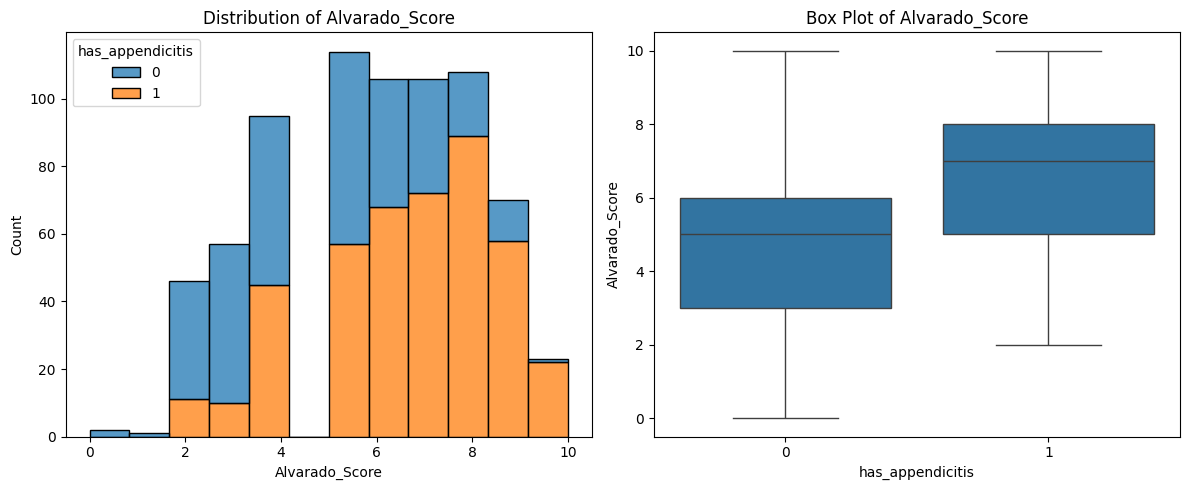

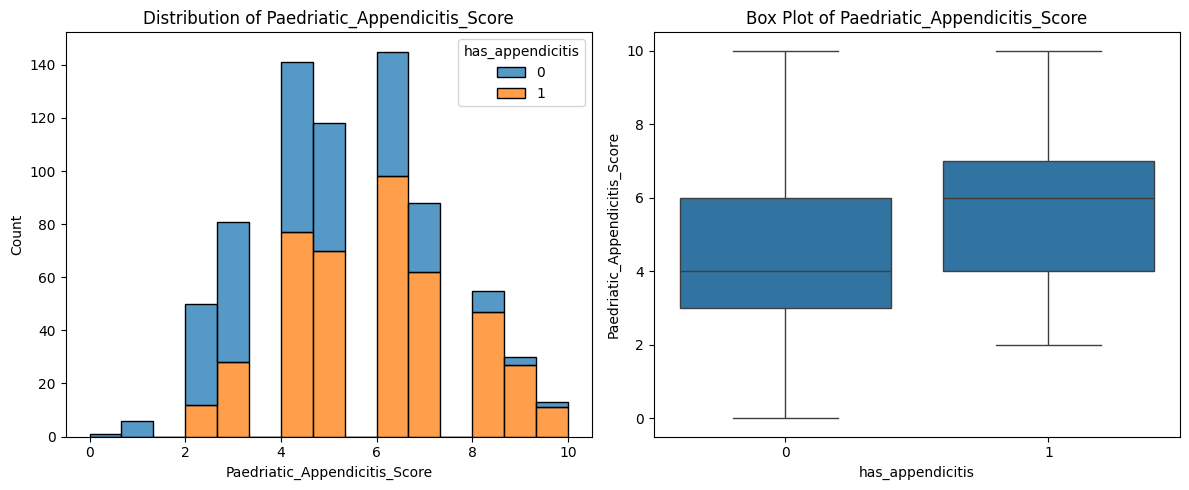

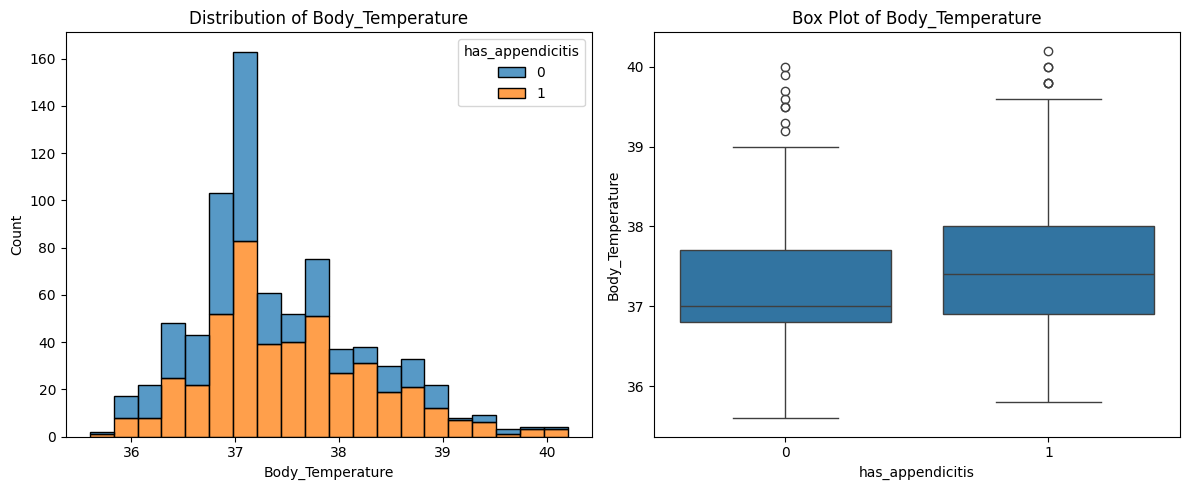

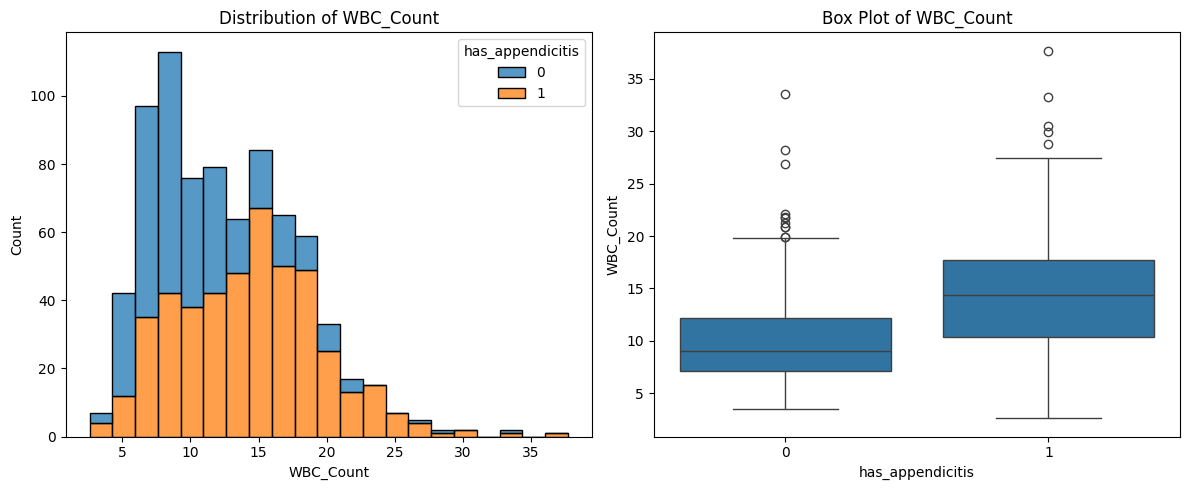

In [16]:
from scipy import stats
import seaborn as sns

key_indicators = ['Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Body_Temperature', 'WBC_Count' ] #'CRP'

for indicator in key_indicators:
    plt.figure(figsize=(12, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=indicator, hue='has_appendicitis', multiple="stack")
    plt.title(f'Distribution of {indicator}')
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='has_appendicitis', y=indicator)
    plt.title(f'Box Plot of {indicator}')
    
    plt.tight_layout()
    plt.show()
    



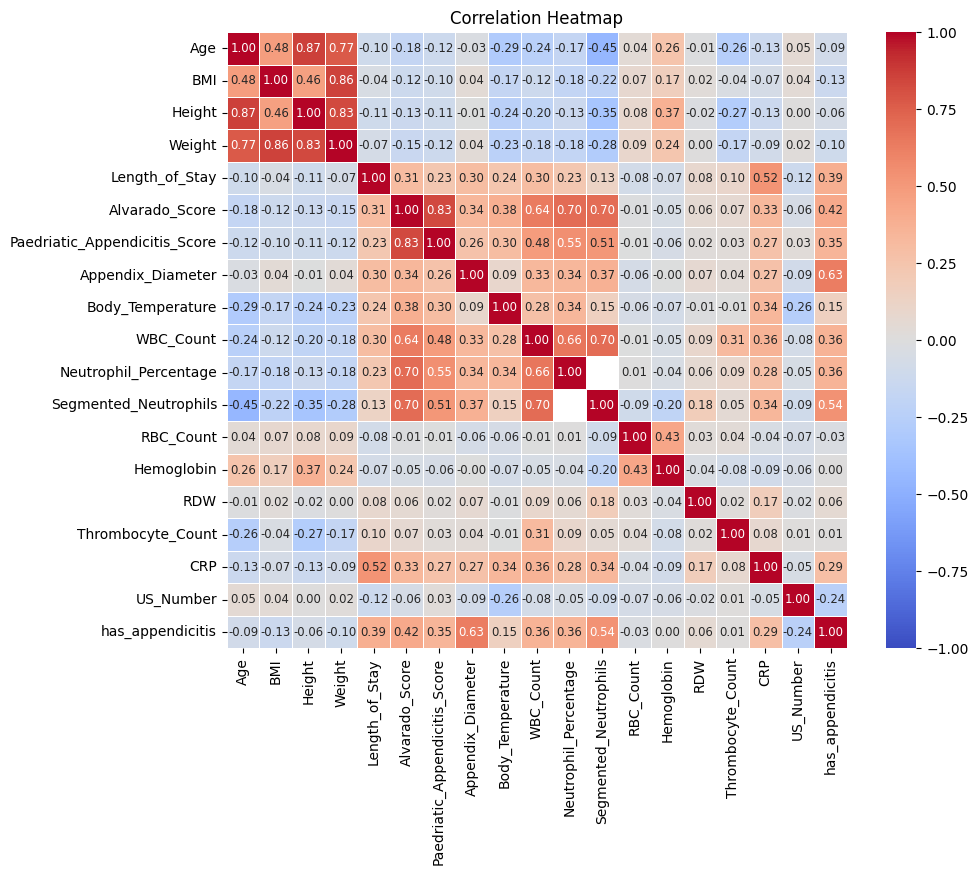

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.select_dtypes([int, float]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": "small"})

plt.title('Correlation Heatmap')
plt.show()

From the correlation plot, we can see that the Alvarado Score and Pediatric Appendicitis score are highly correlated with the metrics that are used to calculate them, such as the white blood cell count and body temperature. Therefore we need to drop these two columns.

The variables that seem more correlated with has_appendicitis are the appendix diameter (which is measured using ultra sound) and segmented neutrophils (which indicate an inflamatory response).

# Data preparation

I'll drop the other target variables different from "has_appendicitis", we can't use them to predict as they're directly related to the condition of wether the patient has appendicitis or not.

I'll remove variables that are calculated based on other parameters present such the Alvarado score and the Pediatric appendicitis score.

The lenght of stay is unavailable at prediction time, therefore we can't use it in our model.

And finally, verify and remove variables that are not usually available (>90% nulls).


In [18]:

df = pd.read_excel('data/app_data.xlsx')

cond1 = df['Diagnosis'].notna()

df = df[cond1].reset_index(drop=True)

In [19]:
import pandas as pd
import numpy as np

def analyze_dataframe(df):
    """
    Analyzes a dataframe and returns a summary of data types and unique values
    """
    columns = []
    dtypes = []
    unique_values = []
    null_counts = []
    null_pct = []
    
    for column in df.columns:
        columns.append(column)
        dtypes.append(str(df[column].dtype))
        null_counts.append(df[column].isnull().sum())
        null_pct.append(df[column].isnull().sum()/len(df))
        
        # Get unique values based on data type top values/range
        if pd.api.types.is_numeric_dtype(df[column]):
            if df[column].dtype == bool:
                unique_vals = list(df[column].unique())
            else:
                unique_vals = f"Range: [{df[column].min():.2f} - {df[column].max():.2f}]"
        else:
            unique_vals = list(df[column].value_counts().head(5).index)
            
        unique_values.append(unique_vals)
    
    summary_df = pd.DataFrame({
        'Column': columns,
        'Data Type': dtypes,
        'Null Count': null_counts,
        'Nulls (%)': null_pct,
        'Top Values/Range': unique_values
    })
    
    print(f"\nTotal Rows: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    
    return summary_df

analyze_dataframe(df)


Total Rows: 780
Total Columns: 58


,Column,Data Type,Null Count,Nulls (%),Top Values/Range
0,Age,float64,0,0.000000,Range: [0.00 - 18.36]
1,BMI,float64,26,0.033333,Range: [7.83 - 38.16]
2,Sex,object,1,0.001282,"[male, female]"
3,Height,float64,25,0.032051,Range: [53.00 - 192.00]
4,Weight,float64,2,0.002564,Range: [3.96 - 103.00]
5,Length_of_Stay,float64,3,0.003846,Range: [1.00 - 28.00]
6,Management,object,0,0.000000,"[conservative, primary surgical, secondary sur..."
7,Severity,object,0,0.000000,"[uncomplicated, complicated]"
8,Diagnosis_Presumptive,object,1,0.001282,"[appendicitis, no appendicitis, Gastroenteriti..."
9,Diagnosis,object,0,0.000000,"[appendicitis, no appendicitis]"


## Data transformation

We have several binary variables that need transformation, as well as columns with a high number of null values. I'll proceed removing columns with more than 90% of null values. These are usually tests that are only indicated under specific circumnstances and being able to accurately predict without them, will help us simplify the process and provide an accurate diagnosis in a timely manner.

In [20]:
missing_pct = df.isna().sum()/len(df)*100
missing_pct[missing_pct > 50].sort_values(ascending=False)

Abscess_Location               98.333333
Gynecological_Findings         96.666667
Conglomerate_of_Bowel_Loops    94.487179
Segmented_Neutrophils          93.076923
Ileus                          92.307692
Perfusion                      91.923077
Enteritis                      91.538462
Appendicolith                  91.153846
Coprostasis                    90.897436
Perforation                    89.615385
Appendicular_Abscess           89.102564
Bowel_Wall_Thickening          87.307692
Lymph_Nodes_Location           84.487179
Target_Sign                    82.307692
Meteorism                      82.051282
Pathological_Lymph_Nodes       73.974359
Appendix_Wall_Layers           72.051282
Surrounding_Tissue_Reaction    67.692308
dtype: float64

In [21]:
# transform target variable
df['has_appendicitis'] = (df['Diagnosis']=="appendicitis").astype('int')

# drop other target variables, we can't use them to predict
df.drop(columns=['Severity', 'Diagnosis', 'Management'], inplace=True)

# drop variables that are calculated based on other parameters present
df.drop(columns=['Paedriatic_Appendicitis_Score', 'Alvarado_Score'], inplace=True)

# lenght of stay unavailable at prediction time
df.drop(columns=['Diagnosis_Presumptive', 'Length_of_Stay'], inplace=True)

# ultrasound
us_variables = ['Appendix_on_US', 'Appendix_Diameter', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 
                'Surrounding_Tissue_Reaction', 'Pathological_Lymph_Nodes','Bowel_Wall_Thickening', 'Coprostasis', 'Meteorism']

# drop variables that are not usually available (>90% nulls)
nulls_treshold = 90
nulls_to_drop = missing_pct[missing_pct > nulls_treshold].index
print(f"The following columns will be dropped due to having {nulls_treshold}% of nulls:", ", ".join(nulls_to_drop))

df.drop(columns=nulls_to_drop, inplace=True)

The following columns will be dropped due to having 90% of nulls: Segmented_Neutrophils, Appendicolith, Perfusion, Abscess_Location, Conglomerate_of_Bowel_Loops, Ileus, Coprostasis, Enteritis, Gynecological_Findings


In [22]:
import numpy as np

def get_summary(var, data):
    pct_nan = round(df[var].isna().sum()/len(df)*100, 2)
    return f"{var}: {len(data.unique())} unique values: {df[var].unique()}.  {pct_nan}% null values"


binary_vars = ['Surrounding_Tissue_Reaction',  'Pathological_Lymph_Nodes', 'Dysuria', 'Bowel_Wall_Thickening', 
               'Conglomerate_of_Bowel_Loops',  'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
               'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite',
               # described as categorical, however, they are binary (yes/no) variables
               'Neutrophilia', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 
               'Free_Fluids', 'Target_Sign', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis']


binary_vars = [var for var in binary_vars if var in df.columns]

for var in binary_vars:
    print(get_summary(var, df[var]))


for var in binary_vars:
    if df[var].dtype == 'O':
        df[var] = np.select([df[var]=='yes', df[var]=='no'], [1, 0], default=np.nan)

Surrounding_Tissue_Reaction: 3 unique values: ['yes' nan 'no'].  67.69% null values
Pathological_Lymph_Nodes: 3 unique values: ['yes' nan 'no'].  73.97% null values
Dysuria: 3 unique values: ['no' 'yes' nan].  3.46% null values
Bowel_Wall_Thickening: 3 unique values: [nan 'no' 'yes'].  87.31% null values
Appendix_on_US: 3 unique values: ['yes' 'no' nan].  0.38% null values
Migratory_Pain: 3 unique values: ['no' 'yes' nan].  0.9% null values
Lower_Right_Abd_Pain: 3 unique values: ['yes' 'no' nan].  0.77% null values
Contralateral_Rebound_Tenderness: 3 unique values: ['yes' 'no' nan].  1.67% null values
Coughing_Pain: 3 unique values: ['no' 'yes' nan].  1.79% null values
Nausea: 3 unique values: ['no' 'yes' nan].  0.77% null values
Loss_of_Appetite: 3 unique values: ['yes' 'no' nan].  1.03% null values
Neutrophilia: 3 unique values: ['no' 'yes' nan].  6.15% null values
Psoas_Sign: 3 unique values: ['yes' 'no' nan].  4.49% null values
Ipsilateral_Rebound_Tenderness: 3 unique values: ['no'

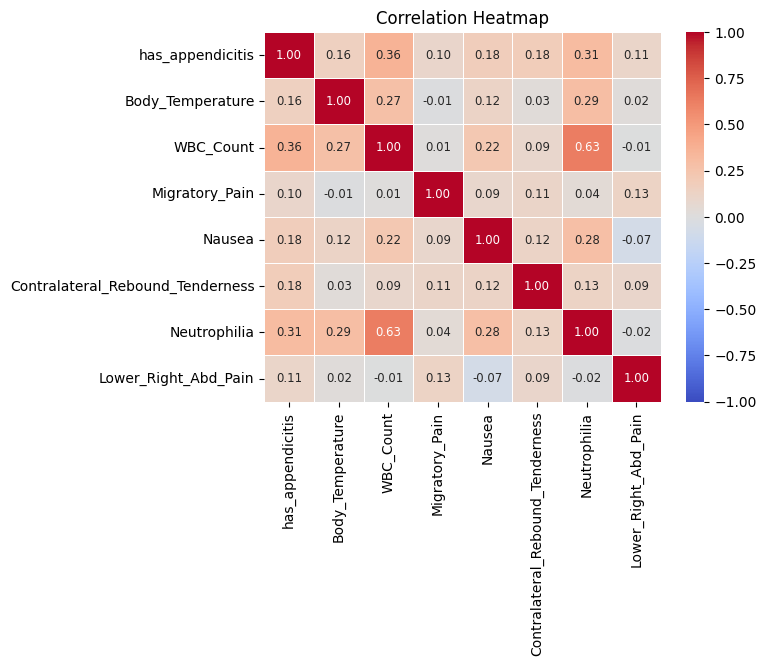

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

alvarado_cols = [ 'has_appendicitis', 'Body_Temperature', 'WBC_Count', 
                  'Migratory_Pain', 'Nausea', 'Contralateral_Rebound_Tenderness', 'Neutrophilia', 'Lower_Right_Abd_Pain']
corr = df[alvarado_cols].corr()

#plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": "small"})

plt.title('Correlation Heatmap')
plt.show()

In [26]:
df['Sex'] = np.select([df['Sex']=='male', df['Sex']=='female', df['Sex']==np.nan], [1, 0, np.nan], default=np.nan)

In [27]:
categorical_columns = df.select_dtypes(include=['object']).columns


for var in categorical_columns:
    print(get_summary(var, df[var]))

# Lymph_Nodes_Location, 

Ketones_in_Urine: 5 unique values: ['++' 'no' nan '+++' '+'].  25.38% null values
RBC_in_Urine: 5 unique values: ['+' 'no' nan '++' '+++'].  26.15% null values
WBC_in_Urine: 5 unique values: ['no' '+' nan '+++' '++'].  25.26% null values
Stool: 5 unique values: ['normal' 'constipation' 'diarrhea' nan 'constipation, diarrhea'].  1.92% null values
Peritonitis: 4 unique values: ['no' 'local' 'generalized' nan].  0.9% null values
Appendix_Wall_Layers: 5 unique values: ['intact' nan 'raised' 'upset' 'partially raised'].  72.05% null values
Perforation: 5 unique values: ['no' nan 'suspected' 'yes' 'not excluded'].  89.62% null values
Appendicular_Abscess: 4 unique values: ['no' nan 'suspected' 'yes'].  89.1% null values
Lymph_Nodes_Location: 27 unique values: ['reUB' nan 're UB' 'Ileozökal' 'UB' 're UB ' 'periumbilikal' 'ileocoekal'
 'mesenterial, re UB' 'mesenterial' 're UB, periumbilikal' 're UB  '
 're UB, ileocoecal' 'ileocoecal' 're UB, re MB' 'MB' 're MB' 'inguinal'
 'periappendikulär 

In [28]:
import unicodedata
import re

def clean_text(text):
    """
    Clean and normalize text to handle special characters and symbols
    """
    if pd.isna(text):
        return text
    
    text = str(text) #.lower()
    
    # Standardize plus symbols
    text = text.replace('+++', 'plus_3')
    text = text.replace('++', 'plus_2')
    text = text.replace('+', 'plus_1')
    
    # Standarize no
    if text.lower().strip() in ['no', 'keine',]:
        return 'no'

    # Remove special characters
    text = ''.join(char for char in unicodedata.normalize('NFKD', text)
                  if unicodedata.category(char)[0] != 'P' or char in 'äöüß')
      
    # Replace special characters with underscore
    text = re.sub(r'[^a-z0-9]+', '_', text)
    
    # Remove multiple underscores
    text = re.sub(r'_+', '_', text)
    text = text.strip('_')
    
    return text


for column in categorical_columns:
    # First clean the values in the original column
    df[column] = df[column].apply(clean_text)
    
    dummy_df = pd.get_dummies(df[column], prefix=column)

    for col in dummy_df.columns:
        dummy_df[col] = dummy_df[col].fillna(False).astype(bool)
    
    # Concatenate and drop original column
    df = pd.concat([df, dummy_df], axis=1).drop(column, axis=1)




In [29]:
df.describe()

,Age,BMI,Sex,Height,Weight,Appendix_on_US,Appendix_Diameter,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,...,Ipsilateral_Rebound_Tenderness,US_Performed,US_Number,Free_Fluids,Target_Sign,Surrounding_Tissue_Reaction,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Meteorism,has_appendicitis
count,780.000000,754.000000,779.000000,755.000000,778.000000,777.000000,498.000000,773.000000,774.000000,767.000000,...,619.000000,777.000000,759.000000,719.000000,138.000000,252.000000,203.000000,99.000000,140.000000,780.000000
mean,11.341863,18.905041,0.517330,147.997616,43.158625,0.648649,7.762651,0.272962,0.947028,0.388527,...,0.061389,0.981982,425.342556,0.431154,0.630435,0.825397,0.758621,0.555556,0.921429,0.593590
std,3.529881,4.387860,0.500021,19.737546,17.397830,0.477700,2.536671,0.445770,0.224122,0.487733,...,0.240237,0.133102,271.722277,0.495582,0.484445,0.380383,0.428978,0.499433,0.270035,0.491478
min,0.000000,7.827983,0.000000,53.000000,3.960000,0.000000,2.700000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.198426,15.721375,0.000000,137.000000,29.500000,0.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,198.500000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,11.437372,18.044121,1.000000,149.500000,41.300000,1.000000,7.500000,0.000000,1.000000,0.000000,...,0.000000,1.000000,398.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,14.040383,21.185877,1.000000,163.000000,54.000000,1.000000,9.100000,1.000000,1.000000,1.000000,...,0.000000,1.000000,613.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,18.360000,38.156221,1.000000,192.000000,103.000000,1.000000,17.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,992.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
df.head()

,Age,BMI,Sex,Height,Weight,Appendix_on_US,Appendix_Diameter,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,...,Lymph_Nodes_Location_periappendikula_r,Lymph_Nodes_Location_periumbilikal,Lymph_Nodes_Location_re,Lymph_Nodes_Location_re_ileocoecal,Lymph_Nodes_Location_re_periumbilikal,Lymph_Nodes_Location_re_re,Lymph_Nodes_Location_rechter_nter_und_ittelbauch,Lymph_Nodes_Location_rechter_nterbauch,Lymph_Nodes_Location_varialzysten,Lymph_Nodes_Location_ymphadenopathie
0,12.68,16.9,0.0,148.0,37.0,1.0,7.1,0.0,1.0,1.0,...,False,False,True,False,False,False,False,False,False,False
1,14.10,31.9,1.0,147.0,69.5,0.0,NaN,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,14.14,23.3,0.0,163.0,62.0,0.0,NaN,0.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,16.37,20.6,0.0,165.0,56.0,0.0,NaN,1.0,1.0,0.0,...,False,False,True,False,False,False,False,False,False,False
4,11.08,16.9,0.0,163.0,45.0,1.0,7.0,0.0,1.0,1.0,...,False,False,True,False,False,False,False,False,False,False


# Model

For the classifier, I'll use the three methods below:

- RandomForestClassifier
- AdaBoostClassifier
- XGBClassifier

Our goal is to accurately predict the patients that have appendicitis. Not delaying the decision making process is critical, as the appendicitis might evolve into peritonitis. Therefore, **the best metric to compare our models is recall**. Regardless, to have a complete understanding of the performance of these models, we'll measure the metrics below.

- accuracy
- precision
- recall
- F1

I'll use a 80/20 split for the training/Test data division with random search for the hyperparameter tuning.


In [31]:
classifier_results = dict()

In [34]:
from sklearn.model_selection import train_test_split


target_variable = "has_appendicitis"
FeaturesName = df.columns.drop(target_variable)


X_train, X_test, Y_train, Y_test = train_test_split(
    df[FeaturesName], df[target_variable], 
    random_state=RANDOM_STATE,
    test_size=0.20,)




In [35]:
Y_train.value_counts()/len(Y_train)

has_appendicitis
1    0.596154
0    0.403846
Name: count, dtype: float64

In [36]:
Y_test.value_counts()/len(Y_test)

has_appendicitis
1    0.583333
0    0.416667
Name: count, dtype: float64

In [37]:
X_train.shape, X_test.shape, 

((624, 84), (156, 84))

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

def classification_metric(Y_real, Y_pred):

    acc = accuracy_score(Y_real, Y_pred)
    precision = precision_score(Y_real, Y_pred)
    recall = recall_score(Y_real, Y_pred)
    f1 = f1_score(Y_real, Y_pred)
    roc = roc_auc_score(Y_real, Y_pred)
    
    metrics = pd.DataFrame({'accuracy' : [acc], 
                            'precision':[precision],
                            'recall':[recall],
                            'ROC':[roc], 
                            'F1': [f1]
                           })
    return metrics


def display_confusion_matrix(Y_real, y_pred):
    cm = confusion_matrix(Y_real, y_pred)
    
    TN = cm[0][0] 
    TP = cm[1][1] 
    FP = cm[0][1] 
    FN = cm[1][0] 
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    group_counts = ['{:,.0f}'.format(value) for value in
                    cm.flatten()]
    
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')
    plt.title('Confusion Matrix: \n Has apendicitis: levels: Yes No', fontsize = 10) 
    plt.xlabel('', fontsize = 15) 
    plt.ylabel('', fontsize = 15)
    
    print("Sum of TP + TN + FP + FN = ", str(TP) + " + " + str(TN) + " + " +str(FP)+ " + "+ str(FN), " = " + str(TP+TN+FP+FN))
    print(len(Y_real) == TP+TN+FP+FN)


In [39]:
N_ITER = 30
CV = 5
SCORING = "recall"

## Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np


param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample', None]
}


rf = RandomForestClassifier(random_state=RANDOM_STATE)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=N_ITER, 
    cv=CV,
    scoring=SCORING,  # 'f1', 'precision', 'recall'
    n_jobs=-1,
    # verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
best_rf = random_search.best_estimator_


Best parameters found:
{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 344}

Best cross-validation score: 0.968


Train


,accuracy,precision,recall,ROC,F1
0,0.995192,0.994638,0.997312,0.994688,0.995973


Test:


,accuracy,precision,recall,ROC,F1
0,0.948718,0.936842,0.978022,0.942857,0.956989


Sum of TP + TN + FP + FN =  89 + 59 + 6 + 2  = 156
True


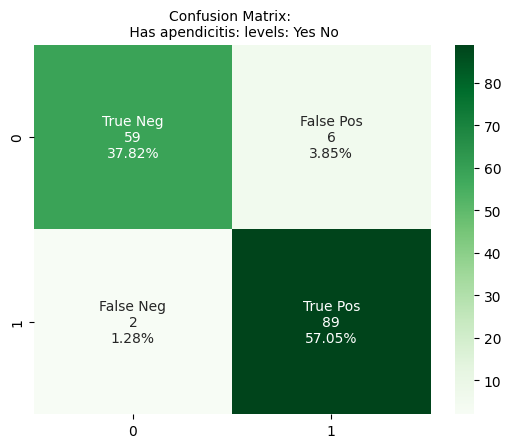

In [41]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)


print("Train")
display(classification_metric(Y_train, y_pred_train))

print("Test:")

classifier_results["RandomForestClassifier"] = classification_metric(Y_test, y_pred_test)

display(classifier_results["RandomForestClassifier"])




display_confusion_matrix(Y_test, y_pred_test)

In [52]:
print("Best model hyperparameters:", best_rf.get_params())


Best model hyperparameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 13, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 344, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## AdaBoostClassifier

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


ada_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # 'median', 'most_frequent', 'constant'
    ('classifier', AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=200,
        algorithm="SAMME", 
        learning_rate=0.5,
        random_state=RANDOM_STATE))
])

param_dist = {
    # AdaBoost parameters
    'classifier__n_estimators': randint(50, 500),
    'classifier__learning_rate': uniform(0.01, 1.0),
    #'classifier__algorithm': ['SAMME'],

    # Estimator (DecisionTreeClassifier) params
    'classifier__estimator__max_depth': randint(1, 10),
    'classifier__estimator__min_samples_split': randint(2, 20),
    'classifier__estimator__min_samples_leaf': randint(1, 10),
    'classifier__estimator__criterion': ['gini', 'entropy'],
    
    # Imputer parameters
    'imputer__strategy': ['mean', 'median', 'most_frequent']
}


random_search = RandomizedSearchCV(
    estimator=ada_clf,
    param_distributions=param_dist,
    n_iter=N_ITER, 
    cv=CV,
    scoring=SCORING, 
    n_jobs=-1,
    # verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
ada_clf = random_search.best_estimator_


#ada_clf.fit(X_train, Y_train)

Best parameters found:
{'classifier__estimator__criterion': 'gini', 'classifier__estimator__max_depth': 9, 'classifier__estimator__min_samples_leaf': 8, 'classifier__estimator__min_samples_split': 17, 'classifier__learning_rate': 0.7573201101373809, 'classifier__n_estimators': 416, 'imputer__strategy': 'mean'}

Best cross-validation score: 0.965


Train


,accuracy,precision,recall,ROC,F1
0,1.0,1.0,1.0,1.0,1.0


Test:


,accuracy,precision,recall,ROC,F1
0,0.929487,0.934783,0.945055,0.926374,0.939891


,accuracy,precision,recall,ROC,F1
0,0.929487,0.934783,0.945055,0.926374,0.939891


Sum of TP + TN + FP + FN =  86 + 59 + 6 + 5  = 156
True


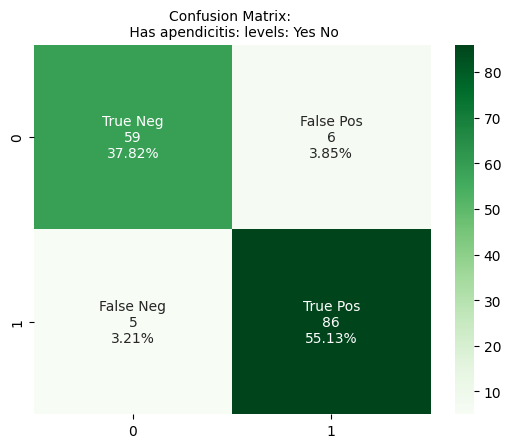

In [45]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred_train = ada_clf.predict(X_train)
y_pred_test = ada_clf.predict(X_test)


print("Train")
display(classification_metric(Y_train, y_pred_train))

print("Test:")

classifier_results["AdaBoostClassifier"] = classification_metric(Y_test, y_pred_test)

display(classifier_results["AdaBoostClassifier"])

display(classification_metric(Y_test, y_pred_test))


display_confusion_matrix(Y_test, y_pred_test)

## XGBClassifier

In [ ]:
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer


param_dist = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__min_child_weight': randint(1, 7),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__reg_alpha': [0, 0.1, 0.5, 1.0],
    'classifier__reg_lambda': [0.1, 0.5, 1.0, 5.0],
    'classifier__scale_pos_weight': [1, 3, 5],
    
    # Imputer parameters
    'imputer__strategy': ['mean', 'median', 'most_frequent']
}


xgb_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', 
        enable_categorical=True,
        seed=RANDOM_STATE,
        random_state=RANDOM_STATE
        ))
])


random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=N_ITER, 
    cv=CV,
    scoring=SCORING,
    n_jobs=-1,
    # verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True,
    error_score='raise'
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
xbg_1 = random_search.best_estimator_


Best parameters found:
{'classifier__colsample_bytree': 0.9815714308010349, 'classifier__gamma': 0.45743219511022426, 'classifier__learning_rate': 0.12104761007663331, 'classifier__max_depth': 11, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 379, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 0.1, 'classifier__scale_pos_weight': 3, 'classifier__subsample': 0.9866619276174678, 'imputer__strategy': 'most_frequent'}

Best cross-validation score: 0.973


Train


,accuracy,precision,recall,ROC,F1
0,0.996795,0.994652,1.0,0.996032,0.997319


Test:


,accuracy,precision,recall,ROC,F1
0,0.935897,0.917526,0.978022,0.927473,0.946809


Sum of TP + TN + FP + FN =  89 + 57 + 8 + 2  = 156
True


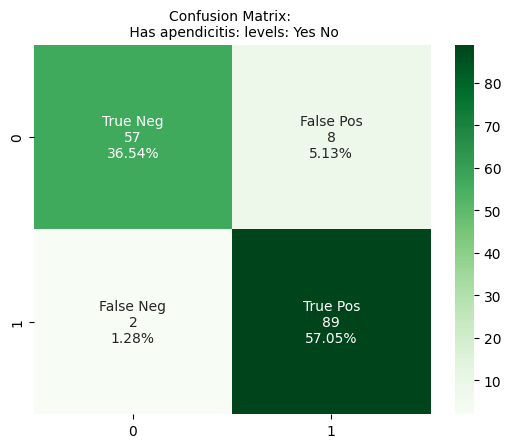

In [47]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred_train = xbg_1.predict(X_train)
y_pred_test = xbg_1.predict(X_test)


print("Train")
display(classification_metric(Y_train, y_pred_train))

print("Test:")

classifier_results["XGBClassifier"] = classification_metric(Y_test, y_pred_test)

display(classifier_results["XGBClassifier"])

display_confusion_matrix(Y_test, y_pred_test)


In [ ]:
combined_results = pd.concat(
    {model: df.T for model, df in classifier_results.items()}, 
    axis=1
)

combined_results.columns = combined_results.columns.droplevel(1) 

combined_results

,RandomForestClassifier,AdaBoostClassifier,XGBClassifier
accuracy,0.948718,0.929487,0.935897
precision,0.936842,0.934783,0.917526
recall,0.978022,0.945055,0.978022
ROC,0.942857,0.926374,0.927473
F1,0.956989,0.939891,0.946809


# Summary 

Given that for our use case, the best metric is recall, the best model for the problem given (predicting if a pediatric patient has appendicitis) is the Random Forest Classifier (recall 97.82%). It is important to mention that the XGBoost Classifier got the same score for recall, however, the Random Forest Classifier achieved better performance accross the other metrics, such as F1 (95.69%) and accuracy (94.87%).

Even after removing several variables, the recall score is similar to the one presented in class. This makes the model more useful for real use cases, because it needs less exams done in a patient.